In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector

import os
from datetime import datetime
from github import Github
from dotenv import load_dotenv
from IPython.display import clear_output

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

load_dotenv()
GITHUB_API_KEY = os.environ['GITHUB_API_KEY']

In [2]:
g = Github(GITHUB_API_KEY)
repo = g.get_user().get_repo('Estate-Prague')
contents = repo.get_contents("data-rental")

In [150]:
df_concated = pd.read_csv(contents[0].download_url)

for file in contents[:41]:
    clear_output(wait=True)
    print(f'Processing file: {file.name}')
    url = file.download_url
    df_single = pd.read_csv(url)
    df_concated = pd.concat([df_concated,df_single],axis=0,ignore_index=True)

df = df_concated.drop_duplicates(subset=['Listing ID','Floor Space'], keep='first')

Processing file: Prague-2022-02-25.csv


In [151]:
def missing_data(df):
    return 100*df.isnull().sum()/len(df)

def droping_data(df):
    
    df = df.drop('Listing ID',axis=1) 
    df = df.drop('New building',axis=1)
    df = df.drop('Front garden',axis=1)
    df = df.drop('Developer name',axis=1)
    df = df.drop('Project name',axis=1)
    df = df.drop('Kód jednotky',axis=1)
    df = df.drop('Administration fee',axis=1)
    df = df.drop('Ownership Type',axis=1)
    df = df.drop('Refundable security deposit',axis=1)
    df = df.drop('Available from',axis=1)
    df = df.drop('Playground',axis=1)
    df = df.drop('Post office',axis=1)
    df = df.drop('Bank',axis=1)
    df = df.drop('Pharmacy',axis=1)
    df = df.drop('Investment Advisor',axis=1)
    df = df.dropna(axis=0,subset=['Floor Space'])
    
    return df

def district_extract(string):
    return string.split('Prague - ')[1]

def rare_district_renaming(district):
    if district not in df['District'].value_counts()[:25].index:
        return 'Other'
    else:
        return district

def feature_engineering(df):
    
    df['Price'] = pd.to_numeric(df['Price'].str.replace('CZK ','').str.replace(',',''))
    df['Fees'] = pd.to_numeric(df['Fees'].str.replace('CZK ','').str.replace(',',''))
    df['Floor Space'] = pd.to_numeric(df['Floor Space'].str.replace(',','').str.replace(' m²',''))
    df['District'] = df['District'].apply(district_extract)
    df['District'] = df['District'].apply(rare_district_renaming)
    
    if df['Public transport stop'].dtype == 'O':
        df['Public transport stop'] = pd.to_numeric(df['Public transport stop'].str.replace(',',''))
    if df['Shop'].dtype == 'O':
        df['Shop'] = pd.to_numeric(df['Shop'].str.replace(',',''))
    if df['Restaurant'].dtype == 'O':
        df['Restaurant'] = pd.to_numeric(df['Restaurant'].str.replace(',',''))
    if df['School'].dtype == 'O':
        df['School'] = pd.to_numeric(df['School'].str.replace(',',''))
    if df['Kindergarten'].dtype == 'O':
        df['Kindergarten'] = pd.to_numeric(df['Kindergarten'].str.replace(',',''))
    if df['Sports field'].dtype == 'O':
        df['Sports field'] = pd.to_numeric(df['Sports field'].str.replace(',',''))
    
    return df

def filtering_outliers(df):
    
    df = df[df['Floor Space']>10]
    df = df[df['Floor Space']<125]
    df = df[df['Price']>3000]
    df = df[df['Price']<30000]
    df = df[df['Fees']<10000]
    df.loc[df['Fees']<400,'Fees'] = np.nan
    
    return df

def fixing_fees(df):
    
    df['ratio'] = df['Price']/df['Fees']
    df.loc[(df['ratio'].between(2.95,3.05)) & (df['Price']>10000),'Fees'] = np.nan
    df = df.drop('ratio',axis=1)
    fees_df = df[['Floor Space','Fees']]
    fees_df = fees_df.dropna()
    fees_coeff = np.polyfit(fees_df['Floor Space'],fees_df['Fees'],1)
    df['Fees'] = df['Fees'].fillna(fees_coeff[0]*df['Floor Space'] + fees_coeff[1])
    
    return df

def total_cost(df):
    
    df['Total price'] = df['Price']+df['Fees']
    df = df.drop('Price',axis=1) 
    df = df.drop('Fees',axis=1) 
    
    return df

def mapping_data(df):
    
    df['Layout'] = df['Layout'].map({
                                        'Small studio':0.5, 
                                        'Studio':0.75,
                                        '1 bedroom with open-plan kitchen':1.5,
                                        '1 bedroom':1,
                                        '2 bedroom with open-plan kitchen':2.5,
                                        '2 bedroom':2,
                                        '3 bedroom with open-plan kitchen':3.5,
                                        '3 bedroom':3,
                                        '4 bedroom with open-plan kitchen':4.5,
                                        '4 bedroom':4,
                                        '5 bedroom with open-plan kitchen':5.5,   
                                        '5 bedroom':5,
                                        '6 bedroom with open-plan kitchen':6.5,
                                        '6 bedroom':6
                                                                                })
    
    
    df['PENB'] = df['PENB'].map({'G':7,'F':6,'E':5,'D':4,'C':3,'B':2,'A':1})
    
    df['Balcony'] = df['Balcony'].map({'Yes':1,'No':0})
    df['Terrace'] = df['Terrace'].map({'Yes':1,'No':0})
    df['Cellar'] = df['Cellar'].map({'Yes':1,'No':0})
    df['Loggia'] = df['Loggia'].map({'Yes':1,'No':0})
    df['Parking'] = df['Parking'].map({'Yes':1,'No':0})
    df['Lift'] = df['Lift'].map({'Yes':1,'No':0})
    df['Garage'] = df['Garage'].map({'Yes':1,'No':0})
    
    return df

def replacing_categories(df):
    
    df['Condition'] = df['Condition'].replace('In need of repair',np.nan)
    df['Condition'] = df['Condition'].replace('Development project','New build')
    df['Building Type'] = df['Building Type'].replace('Wooden building',np.nan)
    df['Total number of floors'] = df['Total number of floors'].replace('Raised ground floor','Ground floor')
    df['Heating'] = df['Heating'].replace('Geothermal heat pump',np.nan)
    df.loc[df['Floor']>10,'Floor'] = 10
    df['Age'] = df['Age'].replace('over 50 years years','over 30 years years')
    df['Age'] = df['Age'].replace('30 to 50 years years','over 30 years years')
    df['Renovation'] = df['Renovation'].replace('Exterior',np.nan)
    df['Renovation'] = df['Renovation'].replace('Bathroom unit',np.nan)
    
    return df

def missing_values(df):
    
    df['Design'] = df['Design'].fillna('Standard materials and solutions')
    df['Floor'] = df['Floor'].fillna(1)
    df['Public transport stop'] = df['Public transport stop'].fillna(df['Public transport stop'].median())
    df['Shop'] = df['Shop'].fillna(df['Shop'].median())
    df['Restaurant'] = df['Restaurant'].fillna(df['Restaurant'].median())
    df['School'] = df['School'].fillna(df['School'].median())
    df['Kindergarten'] = df['Kindergarten'].fillna(df['Kindergarten'].median())
    df['Sports field'] = df['Sports field'].fillna(df['Sports field'].median())
    df['PENB'] = df['PENB'].fillna(np.round(df.groupby('Building Type')['PENB'].transform('mean'),0))
    df['PENB'] = df['PENB'].fillna(5)
        
    return df

In [152]:
df = droping_data(df)
df = feature_engineering(df)
df = filtering_outliers(df)
df = fixing_fees(df)
df = total_cost(df)
df = mapping_data(df)
df = replacing_categories(df)
df = missing_values(df)

In [153]:
y = df['Total price']
X = df.drop('Total price',axis=1)

In [154]:
X = pd.get_dummies(X,drop_first=False)
X.columns = X.columns.str.replace(' ','_')

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101,shuffle=True)

In [156]:
def evaluation(model,X_train,X_test,y_train,y_test):
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    MAE = mean_absolute_error(y_test,y_pred)
    ERR = np.mean(np.abs(y_test-y_pred)*100/y_test)
    MAE2 = mean_absolute_error(y_train,y_pred_train)
    ERR2 = np.mean(np.abs(y_train-y_pred_train)*100/y_train)

    print(f'Mean absolute error (train):\t{np.round(MAE2)} CZK \t({np.round(ERR2,1)}%)')
    print(f'Mean absolute error (test):\t{np.round(MAE)} CZK \t({np.round(ERR,1)}%)')

### XGBoost - All features

In [157]:
xgb0 = xgb.XGBRegressor()
xgb0.fit(X_train,y_train)
evaluation(xgb0,X_train,X_test,y_train,y_test)

Mean absolute error (train):	577.0 CZK 	(3.4%)
Mean absolute error (test):	1850.0 CZK 	(10.7%)


### XGBoost - All features - Hyperparameters tuned

In [160]:
grid_paramters = { 'n_estimators': [200],
                   'eta': uniform(0.001,0.3),
                   'gamma': uniform(0.01,5),
                   'max_depth':[1,2,3,4,5,6,7],
                   'subsample': uniform(0.01,0.99),
                   'colsample_bytree': uniform(0.01,0.99),
                   'colsample_bylevel': uniform(0.01,0.99),
                   'min_child_weight': uniform(0.1,10),
                   'reg_lambda': uniform(0,200),
                   'reg_alpha': uniform(1,750)}

In [161]:
xgb1 = RandomizedSearchCV(estimator = xgb.XGBRegressor(),
                          param_distributions = grid_paramters,
                          scoring = 'neg_mean_absolute_error',
                          n_iter = 500,
                          cv = 5,
                          verbose=1,
                          n_jobs = -1)
xgb1.fit(X_train,y_train)
clear_output(wait=True)
evaluation(xgb1,X_train,X_test,y_train,y_test)

Mean absolute error (train):	1355.0 CZK 	(7.8%)
Mean absolute error (test):	1818.0 CZK 	(10.4%)


### XGBoost - Feature selection - Sequential Feature Selection

In [133]:
# df = df.drop(['District','Public transport stop','Shop','Restaurant','School','Kindergarten','Sports field'],axis='columns')
# y = df['Total price']
# X = df.drop('Total price',axis=1)
# X = pd.get_dummies(X,drop_first=False)
# X.columns = X.columns.str.replace(' ','_')
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101,shuffle=True)

In [162]:
xgb2 = xgb.XGBRegressor(**xgb1.best_params_)
sfs = SequentialFeatureSelector(xgb2,
                                k_features=6,
                                forward=False,
                                floating=False,
                                scoring = 'neg_mean_absolute_error',
                                cv = 3)
sfs.fit(X_train, y_train)
clear_output(wait=True)
scores = pd.DataFrame(sfs.subsets_).transpose()['avg_score'].apply(float)

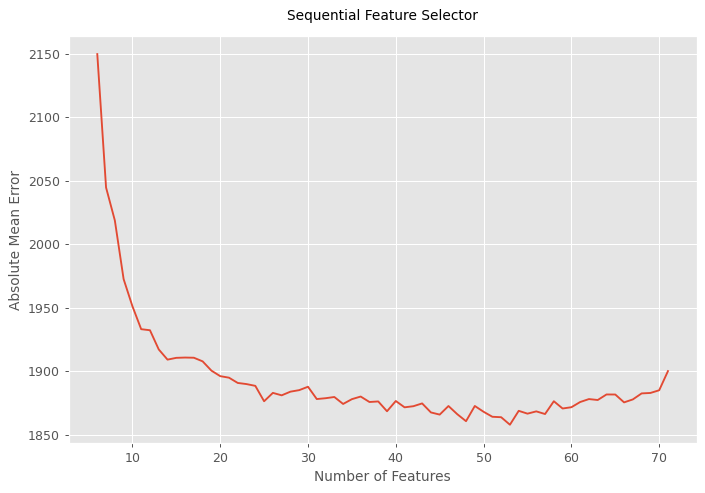

In [163]:
plt.figure(figsize=(9,6),dpi=90)
sns.lineplot(x=scores.index,y=-scores.values)
plt.xlabel("Number of Features", fontsize= 11)
plt.ylabel("Absolute Mean Error", fontsize= 11)
plt.title("Sequential Feature Selector", fontsize= 11, y=1.02);

In [168]:
sfs_selected_features = list(sfs.subsets_[50]['feature_names'])

In [169]:
xgb3 = RandomizedSearchCV(estimator = xgb.XGBRegressor(),
                          param_distributions = grid_paramters,
                          scoring = 'neg_mean_absolute_error',
                          n_iter = 500,
                          cv = 5,
                          verbose=1,
                          n_jobs = -1)
xgb3.fit(X_train[sfs_selected_features],y_train)
clear_output(wait=True)
evaluation(xgb3,X_train[sfs_selected_features],X_test[sfs_selected_features],y_train,y_test)

Mean absolute error (train):	1145.0 CZK 	(6.7%)
Mean absolute error (test):	1834.0 CZK 	(10.6%)


In [170]:
my_selected_features = ['Latitude','Longitude','Layout','Floor Space','Balcony','Terrace','Cellar','Lift','Garage',
                     'Furnishing and Fittings','Condition','Building Type','Design','Heating']

y = df['Total price']
X = df.drop('Total price',axis=1)
X = X[my_selected_features]
X = pd.get_dummies(X,drop_first=False)
X.columns = X.columns.str.replace(' ','_')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101,shuffle=True)

In [171]:
xgb4 = RandomizedSearchCV(estimator = xgb.XGBRegressor(),
                          param_distributions = grid_paramters,
                          scoring = 'neg_mean_absolute_error',
                          n_iter = 500,
                          cv = 5,
                          verbose=1,
                          n_jobs = -1)
xgb4.fit(X_train,y_train)
clear_output(wait=True)
evaluation(xgb4,X_train,X_test,y_train,y_test)

Mean absolute error (train):	1240.0 CZK 	(7.3%)
Mean absolute error (test):	1851.0 CZK 	(10.7%)


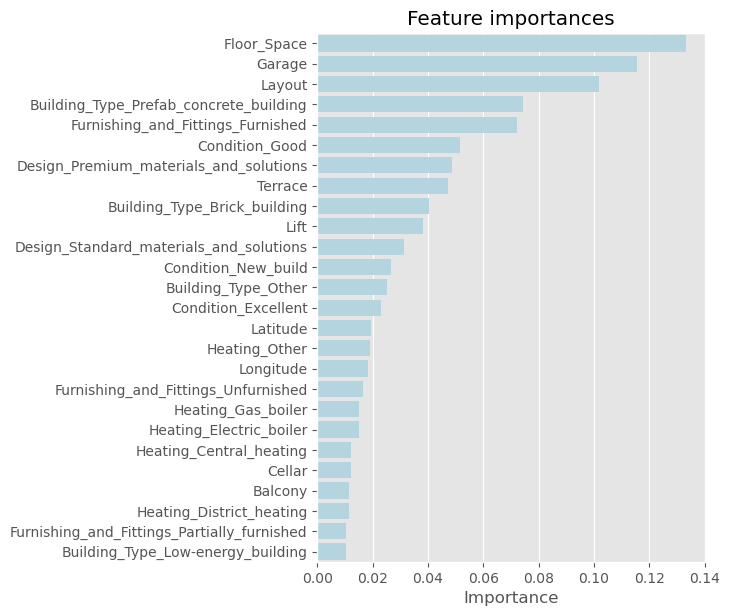

In [176]:
xgb4_ = xgb.XGBRegressor(**xgb4.best_params_)
xgb4_.fit(X_train,y_train)
feat_import =xgb4_.feature_importances_
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
imp_feats = imp_feats[imp_feats['Importance'] > 0.001]
imp_feats = imp_feats.sort_values("Importance",ascending=False)
plt.figure(figsize=(5,7),dpi=100)
sns.barplot(data=imp_feats,y=imp_feats.index,x='Importance',color='lightblue');
plt.title('Feature importances');

In [ ]:
plt.figure(figsize=(9,6),dpi=90)
sns.lineplot(x=list(sfs3.subsets_.keys()),y=-ranking3['avg_score'].apply(float))
plt.xlabel("Number of Features", fontsize= 11)
plt.ylabel("Absolute Mean Error", fontsize= 11)
plt.title("Sequential Feature Selector", fontsize= 11, y=1.02);

In [176]:
sfs = SequentialFeatureSelector(xgb0,
                                k_features=71,
                                forward=True,
                                floating=False,
                                scoring = 'neg_mean_absolute_error',
                                cv = 3)
sfs.fit(X_train, y_train)
clear_output(wait=True)
ranking = pd.DataFrame(sfs.subsets_).transpose()[['avg_score','feature_names']]

In [169]:
xgb2 = xgb.XGBRegressor(**xgb1.best_params_)
sfs2 = SequentialFeatureSelector(xgb2,
                                k_features=71,
                                forward=True,
                                floating=False,
                                scoring = 'neg_mean_absolute_error',
                                cv = 3)
sfs2.fit(X_train, y_train)
clear_output(wait=True)
ranking2 = pd.DataFrame(sfs2.subsets_).transpose()[['avg_score','feature_names']]

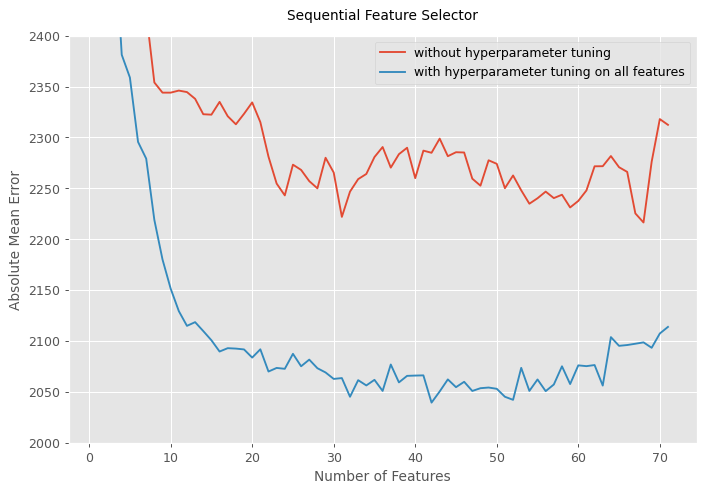

In [179]:
plt.figure(figsize=(9,6),dpi=90)
sns.lineplot(x=list(range(1,len(ranking)+1)),y=-ranking['avg_score'].apply(float))
sns.lineplot(x=list(range(1,len(ranking2)+1)),y=-ranking2['avg_score'].apply(float))
plt.xlabel("Number of Features", fontsize= 11)
plt.ylabel("Absolute Mean Error", fontsize= 11)
plt.ylim(2000,2400)
plt.title("Sequential Feature Selector", fontsize= 11, y=1.02)
plt.legend(labels=["without hyperparameter tuning","with hyperparameter tuning on all features"]);

In [198]:
selected_features_sfs = list(sfs2.subsets_[45]['feature_names'])
X_train_selected_sfs = X_train[selected_features_sfs]
X_test_selected_sfs = X_test[selected_features_sfs]

In [195]:
xgb3 = RandomizedSearchCV(estimator = xgb.XGBRegressor(),
                          param_distributions = grid_paramters,
                          scoring = 'neg_mean_absolute_error',
                          n_iter = 1000,
                          cv = 6,
                          verbose=1,
                          n_jobs = -1)
xgb3.fit(X_train_selected,y_train)
clear_output(wait=True)
evaluation(xgb3,X_train_selected,X_test_selected,y_train,y_test)

Mean absolute error (train):	900.0 CZK 	(5.0%)
Mean absolute error (test):	2076.0 CZK 	(11.9%)


### XGBoost - Feature selection - Embedded Method

In [196]:
# xgb4 = xgb.XGBRegressor(**xgb3.best_params_)
# xgb4.fit(X[selected_features_sfs],y)

# score = np.mean(-cross_val_score(xgb4,X[selected_features],y,cv=KFold(10,shuffle=True),scoring='neg_mean_absolute_error'))
# score = np.round(score,0)

# print('Cross validation score:')
# print(f'{score} CZK')

Cross validation score:
2031.0 CZK


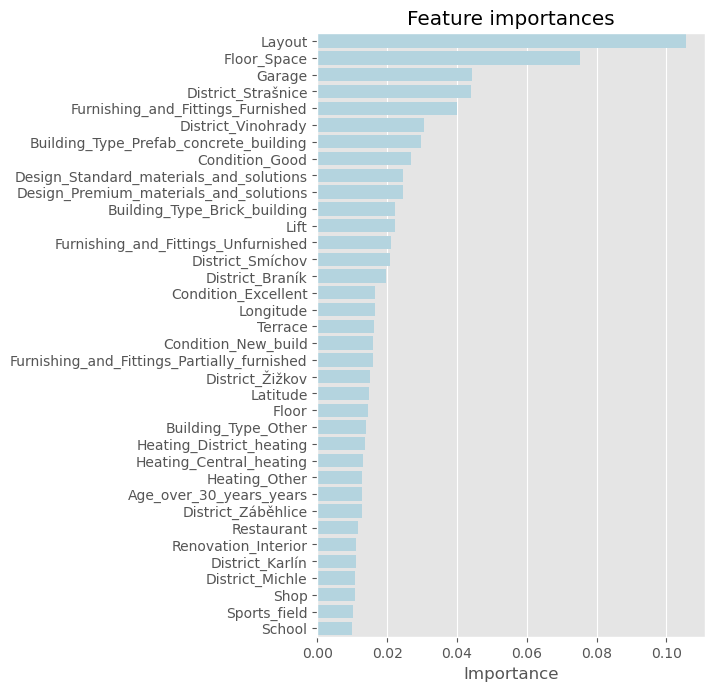

In [14]:
xgb1_ = xgb.XGBRegressor(**xgb1.best_params_)
xgb1_.fit(X_train,y_train)
feat_import = xgb1_.feature_importances_
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
imp_feats = imp_feats[imp_feats['Importance'] > 0.01]
imp_feats = imp_feats.sort_values("Importance",ascending=False)
plt.figure(figsize=(5,8),dpi=100)
sns.barplot(data=imp_feats,y=imp_feats.index,x='Importance',color='lightblue');
plt.title('Feature importances');

In [ ]:
selected_features_emb = ['Latitude','Longitude','Layout','Floor Space','Furnishing and Fittings','Garage','Condition','Building Type','Lift','Floor','Terrace','Heating','PENB']

In [20]:
df = df.drop(['District','Public transport stop','Shop','Restaurant','School','Kindergarten','Sports field'],axis='columns')

In [24]:
xgb5 = RandomizedSearchCV(estimator = xgb.XGBRegressor(),
                          param_distributions = grid_paramters,
                          scoring = 'neg_mean_absolute_error',
                          n_iter = 1000,
                          cv = 6,
                          verbose=1,
                          n_jobs = -1)
xgb5.fit(X_train,y_train)
clear_output(wait=True)
evaluation(xgb5,X_train,X_test,y_train,y_test)

Mean absolute error (train):	1251.0 CZK 	(7.0%)
Mean absolute error (test):	1947.0 CZK 	(11.1%)


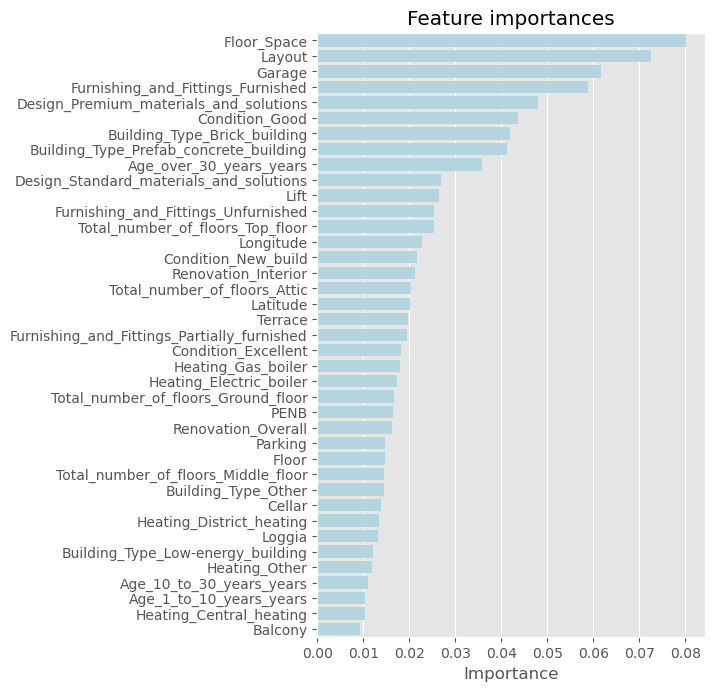

In [27]:
xgb5_ = xgb.XGBRegressor(**xgb5.best_params_)
xgb5_.fit(X_train,y_train)
feat_import =xgb5_.feature_importances_
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
imp_feats = imp_feats[imp_feats['Importance'] > 0.005]
imp_feats = imp_feats.sort_values("Importance",ascending=False)
plt.figure(figsize=(5,8),dpi=100)
sns.barplot(data=imp_feats,y=imp_feats.index,x='Importance',color='lightblue');
plt.title('Feature importances');

In [48]:
xgb5 = RandomizedSearchCV(estimator = xgb.XGBRegressor(),
                          param_distributions = grid_paramters,
                          scoring = 'neg_mean_absolute_error',
                          n_iter = 1000,
                          cv = 6,
                          verbose=1,
                          n_jobs = -1)
xgb5.fit(X_train,y_train)
clear_output(wait=True)
evaluation(xgb5,X_train,X_test,y_train,y_test)

Mean absolute error (train):	1181.0 CZK 	(6.9%)
Mean absolute error (test):	1842.0 CZK 	(10.6%)


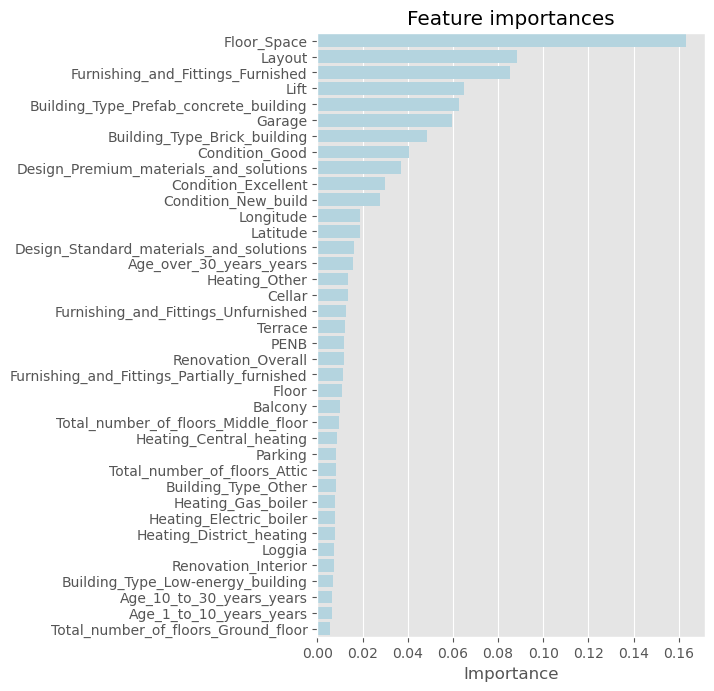

In [49]:
xgb5_ = xgb.XGBRegressor(**xgb5.best_params_)
xgb5_.fit(X_train,y_train)
feat_import =xgb5_.feature_importances_
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
imp_feats = imp_feats[imp_feats['Importance'] > 0.005]
imp_feats = imp_feats.sort_values("Importance",ascending=False)
plt.figure(figsize=(5,8),dpi=100)
sns.barplot(data=imp_feats,y=imp_feats.index,x='Importance',color='lightblue');
plt.title('Feature importances');

In [76]:
sfs3 = SequentialFeatureSelector(xgb5_,
                                k_features=5,
                                forward=False,
                                floating=False,
                                scoring = 'neg_mean_absolute_error',
                                cv = 3)
sfs3.fit(X_train, y_train)
clear_output(wait=True)
ranking3 = pd.DataFrame(sfs3.subsets_).transpose()[['avg_score','feature_names']]

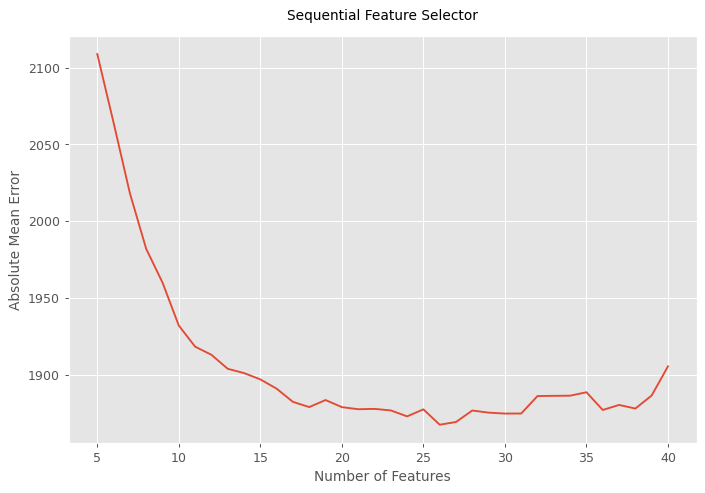

In [77]:
plt.figure(figsize=(9,6),dpi=90)
sns.lineplot(x=list(sfs3.subsets_.keys()),y=-ranking3['avg_score'].apply(float))
plt.xlabel("Number of Features", fontsize= 11)
plt.ylabel("Absolute Mean Error", fontsize= 11)
plt.title("Sequential Feature Selector", fontsize= 11, y=1.02);

In [88]:
X.columns

Index(['Latitude', 'Longitude', 'Layout', 'Floor_Space', 'Floor', 'Balcony',
       'Terrace', 'Cellar', 'Loggia', 'Parking', 'Lift', 'Garage', 'PENB',
       'Investment_Advisor', 'Furnishing_and_Fittings_Furnished',
       'Furnishing_and_Fittings_Partially_furnished',
       'Furnishing_and_Fittings_Unfurnished', 'Condition_Excellent',
       'Condition_Good', 'Condition_New_build', 'Building_Type_Brick_building',
       'Building_Type_Low-energy_building', 'Building_Type_Other',
       'Building_Type_Prefab_concrete_building',
       'Design_Premium_materials_and_solutions',
       'Design_Standard_materials_and_solutions', 'Heating_Central_heating',
       'Heating_District_heating', 'Heating_Electric_boiler',
       'Heating_Gas_boiler', 'Heating_Other', 'Total_number_of_floors_Attic',
       'Total_number_of_floors_Ground_floor',
       'Total_number_of_floors_Middle_floor',
       'Total_number_of_floors_Top_floor', 'Age_1_to_10_years_years',
       'Age_10_to_30_years_years', 

In [92]:
sfs3.subsets_[6]['feature_names']

('Latitude',
 'Longitude',
 'Floor_Space',
 'Furnishing_and_Fittings_Furnished',
 'Condition_New_build',
 'Building_Type_Brick_building')

In [ ]:
selected_features_emb = ['Latitude','Longitude','Layout','Floor Space','Balcony','Terrace','Cellar','Lift','Garage','Furnishing and Fittings','Condition','Building Type','Design','Heating']


In [24]:
columns_to_keep = ['Latitude','Longitude','Layout','Floor Space','Furnishing and Fittings','Terrace','Lift','Garage','Condition','Building Type','Design','Age']
X_sample = df_unique[columns_to_keep]
X_sample = pd.get_dummies(X_sample,drop_first=False)
X_sample.columns = X_sample.columns.str.replace(' ','_')

In [25]:
g = Github(GITHUB_API_KEY)
repo = g.get_user().get_repo('Estate-Prague')
contents = repo.get_contents("data-rental")

xs=[]
ys=[]

for file in contents:
    clear_output(wait=True)
    print(f'Processing file: {file.name}')
    url = file.download_url
    df = pd.read_csv(url)
    df = preprocessing(df)
    y = df['Total price']

    columns_to_keep = ['Latitude','Longitude','Layout','Floor Space','Furnishing and Fittings','Terrace','Lift','Garage','Condition','Building Type','Design','Age']
    X = df[columns_to_keep]
    X = pd.get_dummies(X,drop_first=False)
    X.columns = X.columns.str.replace(' ','_')

    xgb3 = xgb.XGBRegressor(colsample_bylevel=0.35,
                            colsample_bytree=1,
                            eta=0.18,
                            gamma=1.4,
                            max_depth=6,
                            min_child_weight=3,
                            n_estimators=250,
                            reg_alpha=500,
                            reg_lambda=180,
                            subsample=0.6)
    xgb3.fit(X,y)
    y_sample_predition = xgb3.predict(X_sample)
    ys.append(y_sample_predition)
    xs.append(datetime.strptime(file.name, 'Prague-%Y-%m-%d.csv'))

Processing file: Prague-2022-04-02.csv


In [26]:
price_change = []
for ys_i in ys:
    delta = ((ys_i-ys[0])/ys[0]).mean()*100
    price_change.append(delta)

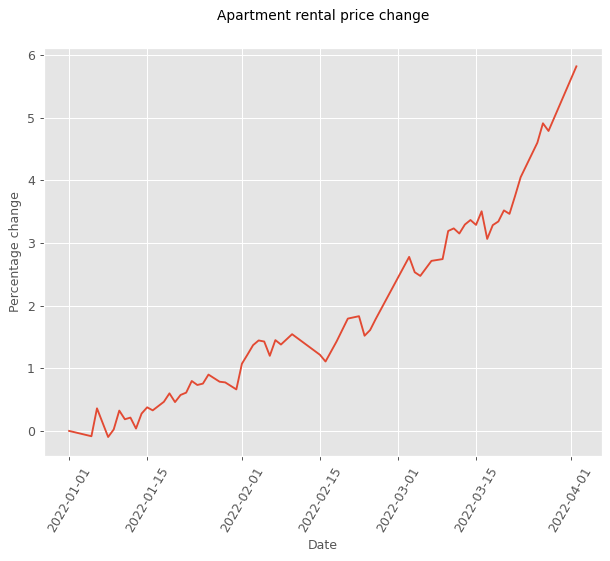

In [30]:
plt.figure(figsize=(8,6),dpi=90)
sns.lineplot(x=xs,y=price_change)
plt.xlabel("Date", fontsize= 10)
plt.ylabel("Percentage change", fontsize= 10)
plt.title("Apartment rental price change", fontsize= 11, y=1.05)
plt.xticks(rotation=60);